In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.randbench
imported experiments.two_qubit.twoqutrit_state_tomogr

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
# expt_path=os.getcwd()+'\data\data_221007'
expt_path=os.getcwd()+'\data\data_221215'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_221215


In [5]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


# Set the qubits/resonators to probe

In [48]:
qubits = [3, 1] # for eg-gf swap, always list the 2nd qubit here as the 2nd qubit in the order eg-gf

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [8]:
im = InstrumentManager(ns_address='192.168.14.1')

In [10]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 6100000000.0
set power to 10.0


In [9]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, envelope mem

# Pulse probe coupling spectroscopy

Sweep qubit A frequency after applying pi pulse to qubit B.

In [42]:
qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_coupling_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 15
npts = 101

qZZspec.cfg.expt = dict(
    start=qZZspec.cfg.device.qubit.f_ge[qubits[0]]-span/2, # resonator frequency to be mixed up [MHz]
    # start=3600,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    pulseB=True, # Whether to apply pi pulse to qubit B
    length=1, # qubit 0 probe constant pulse length [us]
    gain=500, # qubit 0 const pulse gain
    qubits=qubits,
)

# qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

print(qZZspec.cfg)

qZZspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [73, 128, 46, 58], 'f_ge': [826.6246419342525, 3470.204764189285, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.9, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [637.2764733473786, 3369.7243020025294, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.9, -1, 2681.7, 2384.37], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [23801, 21866, 22539, 28755], 'sigma': [0.0403, 0.0197, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [30000, 16999, 20765, 29402], 'sigma': [0.02, 0.015, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0173, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3000, 0, 2750, 3000], 'sigma': [0.396, 0, 0.232, 0.276], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [812.846, -807.358, -79.784, 81.67042225717739], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.9, 0.27, 0.27, 0.85], 'readout

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3468.889513688846, HWHM 0.3174043058081399
Found peak in I at [MHz] 3468.8723749541655, HWHM 0.30069171403020345
Found peak in Q at [MHz] 3468.90244152312, HWHM 0.3261141359519556


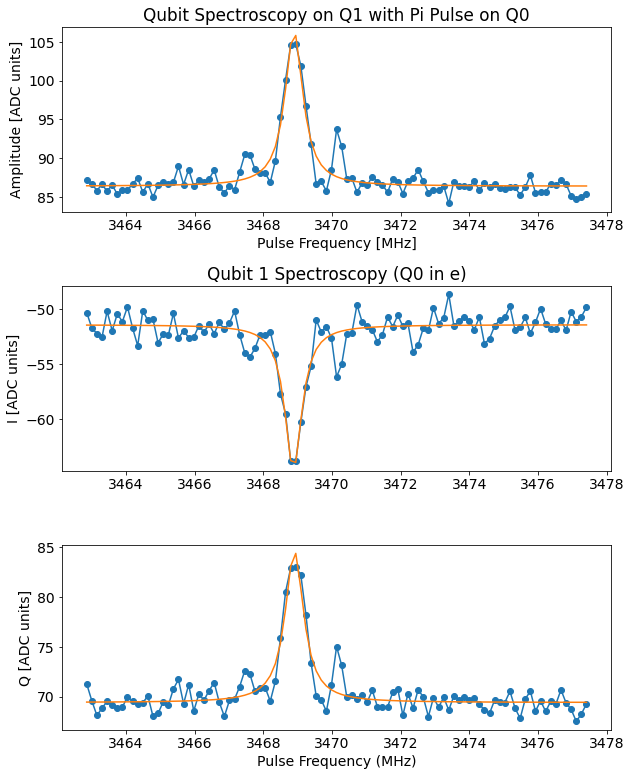

In [43]:
# # TESTING
# qZZspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_coupling_spectroscopy_qubit01.h5')
# data = qZZspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qZZspec.display(data=data, fit=True)

qZZspec.analyze(fit=True, signs=[1, -1, 1])
qZZspec.display(fit=True, signs=[1, -1, 1])

In [55]:
qZZspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_qubit_coupling_spectroscopy_qubit01.h5


# Length rabi for Q1 with QA in e

In [51]:
lengthrabiZZ = meas.LengthRabiPiZZExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_ZZ_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

lengthrabiZZ.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=101,
    reps=1000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubits=qubits,
)
# lengthrabiZZ.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabiZZ.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [73, 128, 46, 58], 'f_ge': [826.6246419342525, 3470.204764189285, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [637.2764733473786, 3369.7243020025294, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.9, -1, 2681.7, 2384.37], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [23801, 21866, 22539, 28755], 'sigma': [0.0403, 0.0197, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [30000, 16999, 20765, 29402], 'sigma': [0.02, 0.015, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.018, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3000, 0, 2750, 3000], 'sigma': [0.396, 0, 0.232, 0.276], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [812.846, -807.358, -79.784, 81.67042225717739], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.9, 0.27, 0.27, 0.85]

  0%|          | 0/101 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 83.99916000000002, which is out of bounds 0.3535318181818182 to 53.02977272727273. Instead init to 26.691652272727275
Pi length from avgi data (qubit B) [us]: 0.021599656517148482
	Pi/2 length from avgi data (qubit B) [us]: 0.010799828258574241
Pi length from avgq data (qubit B) [us]: 0.021455783942806932
	Pi/2 length from avgq data (qubit B) [us]: 0.010727891971403466


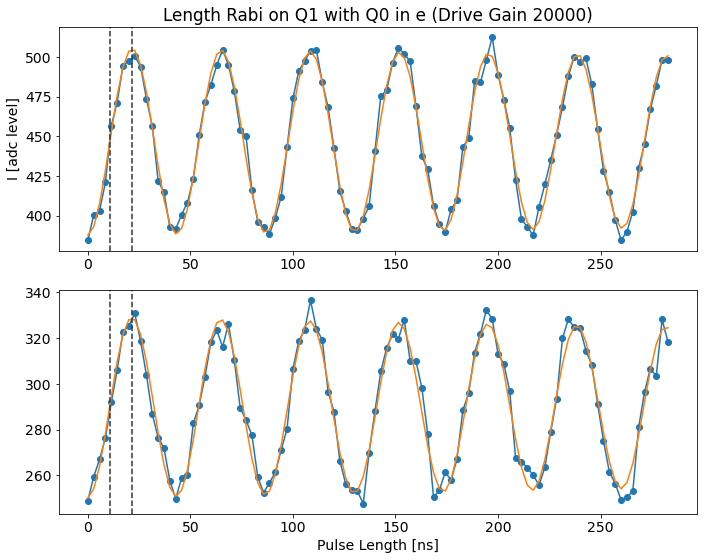

In [52]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabiZZ.analyze(data=temp_data, fit=True)

lengthrabiZZ.analyze(fit=True)
lengthrabiZZ.display(fit=True)

In [24]:
lengthrabiZZ.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00000_length_rabi_ZZ_qubit31.h5


# Pulse probe eg-gf spectroscopy

In [12]:
f_ge = np.array([4823.0681204610527, 3473.31, 4153.92796237453135, 4447.5819924260869])
f_ef = np.array([4633.210668158286, 3364.2434148826505, 4000-71.90192894145498, 4275.76433968698353]) # [MHz]

# print(f_ge + f_ef - f_ge[1])
print(f_ge[1] + f_ef[1] - f_ge)

[2014.48529442 3364.24341488 2683.62545251 2389.97142246]


In [15]:
qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EgGf_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 40
npts = 150

qEgGfspec.cfg.expt = dict(
    # start=qEgGfspec.cfg.device.qubit.f_ge[1] - span/2, # Eg-Gf probe frequency [MHz]
    start=qEgGfspec.cfg.device.qubit.f_EgGf[qubits[0]] - span/2, # Eg-Gf probe frequency [MHz]
    # start=1900,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=2, # Eg-Gf probe constant pulse length [us]
    gain=3000, # Eg-Gf const pulse gain
    qubits=qubits,
)
# qEgGfspec.cfg.device.readout.relax_delay = [50]*4
# qEgGfspec.cfg.device.readout.relax_delay = [100, 100, 100, 100]
# qEgGfspec.cfg.device.readout.length = [5, 5, 5, 5]

print(qEgGfspec.cfg)

qEgGfspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [806.087775593827, 3464.4496477749913, 145.572034953271, 425.57], 'f_Q1_ZZ': [3463.6655790699174, 0, 3459.718643790527, 3463.5163174610875], 'f_ef': [617.0457654660589, 3364.2604416148333, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2022.6223138, 3364.26044161, 2683.13805444, 2403.14008939], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30306, 22147, 24653, 28755], 'sigma': [0.0326, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [13626, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [30000, 0, 15880, 30000], 'sigma': [0.022877223175459725, 0, 0.05739835717369027, 0.016160253718707353], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.946, -812.617, -73.825, 87.436], 'lo_sideband'

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in avgi data (qubit A) at [MHz] 2011.0772790316635, HWHM 1.0630988234280279
Found peak in avgq data (qubit A) at [MHz] 2011.059302455054, HWHM 0.9029036822409753
Found peak in avgi data (qubit B) at [MHz] 2011.0325283890313, HWHM 0.9407213882735002
Found peak in avgq data (qubit B) at [MHz] 2011.0143256501299, HWHM 0.9636483374316271


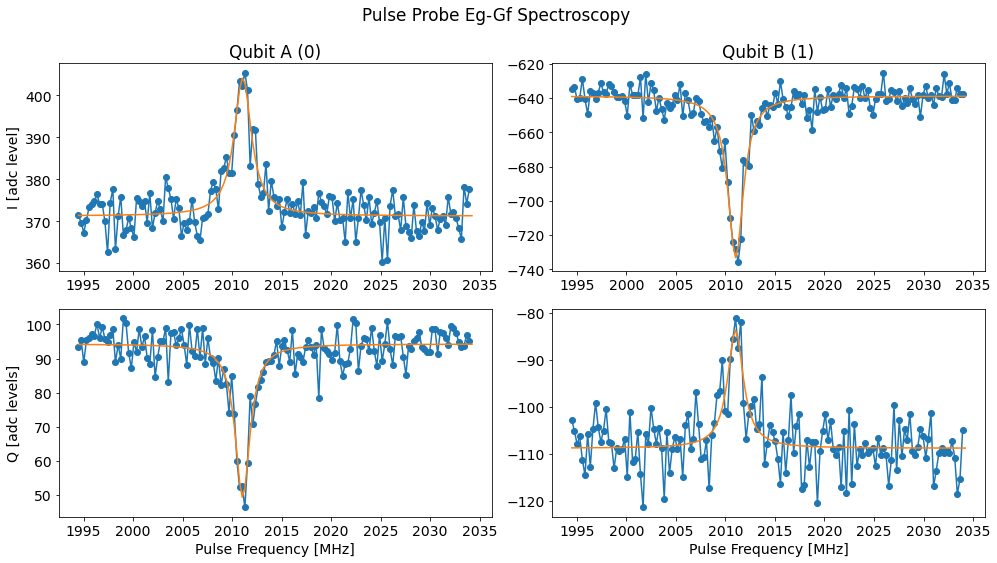

In [15]:
# # TESTING
# qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_EgGf_spectroscopy_qubit01.h5')
# data = qEgGfspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qEgGfspec.display(data=data, fit=True)

# qEgGfspec.analyze(fit=False)
sign = [[1, -1], [-1, 1]] # [iA, qA], [iB, qB]
qEgGfspec.analyze(fit=True, sign=sign)
qEgGfspec.display(fit=True, sign=sign)

In [16]:
qEgGfspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_qubit_EgGf_spectroscopy_qubit01.h5


### Pulse probe EgGF power sweep

In [18]:
sweepspecEgGf = meas.PulseProbeEgGfSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_len_sweep_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_f = 75
npts_f = 150
# npts_f = 10

span_len = 20
npts_len = 10
# npts_len = 3

sweepspecEgGf.cfg.expt = dict(
    start_f=sweepspecEgGf.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # Eg-Gf probe frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_len=1,
    step_len=int(span_len/npts_len), # len step size
    expts_len=npts_len, # Number experiments stepping len from start
    reps=500,
    rounds=40, # Number averages per point
    gain=30000, # ef const pulse length [us]
    qubits=qubits,
)
sweepspecEgGf.cfg.device.readout.relax_delay = [100, 100, 100, 100]
sweepspecEgGf.cfg.device.readout.length = [5, 5, 5, 5]
sweepspecEgGf.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

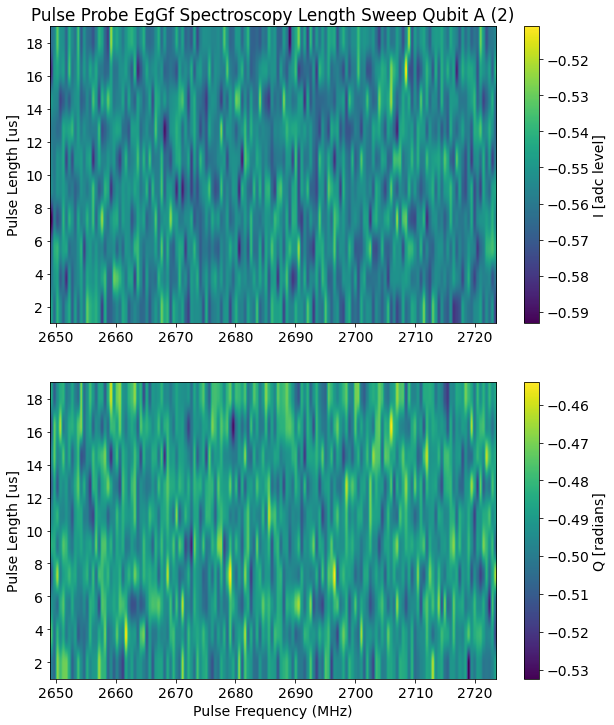

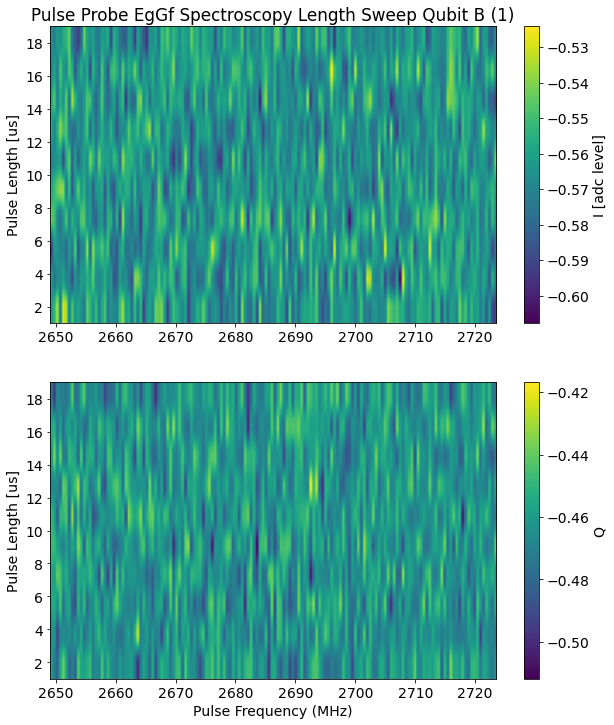

In [19]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

sweepspecEgGf.analyze()
sweepspecEgGf.display()

# Rabi eg-gf chevron (freq vs. amplitude)

In [31]:
rabiEgGfFreqGainChevron = meas.EgGfFreqGainChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_gainlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_gain = 4000
npts_gain = 40

span_f = 4 # MHz
npts_f = 50

rabiEgGfFreqGainChevron.cfg.expt = dict(
    start_gain=1500, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # start freq [MHz],
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # start freq [MHz],
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f, # number of different freq experiments, 
    rounds=50,
    reps=10,
    # pi_EgGf_sigma=0.600, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='const',
    qubits=qubits,
)

# rabiEgGfFreqGainChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqGainChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiEgGfFreqGainChevron.cfg)

rabiEgGfFreqGainChevron.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [810.826541944993, 3464.727488396267, 145.572034953271, 425.57], 'f_Q1_ZZ': [3463.6655790699174, 0, 3459.718643790527, 3463.5163174610875], 'f_ef': [611.098326885819, 3364.253, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2010.8, 0, 2678.7, 2394.96], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [16026, 22147, 24653, 28755], 'sigma': [0.066, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [16026, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [30000, 0, 15880, 30000], 'sigma': [0.022877223175459725, 0, 0.05739835717369027, 0.016160253718707353], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [4250, 0, 2679, 2850], 'sigma': [0.171, 0, 0.227, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.946, -812.617, -73.825, 87.436], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.86, 0.86, 0.48, 0

  0%|          | 0/50 [00:00<?, ?it/s]

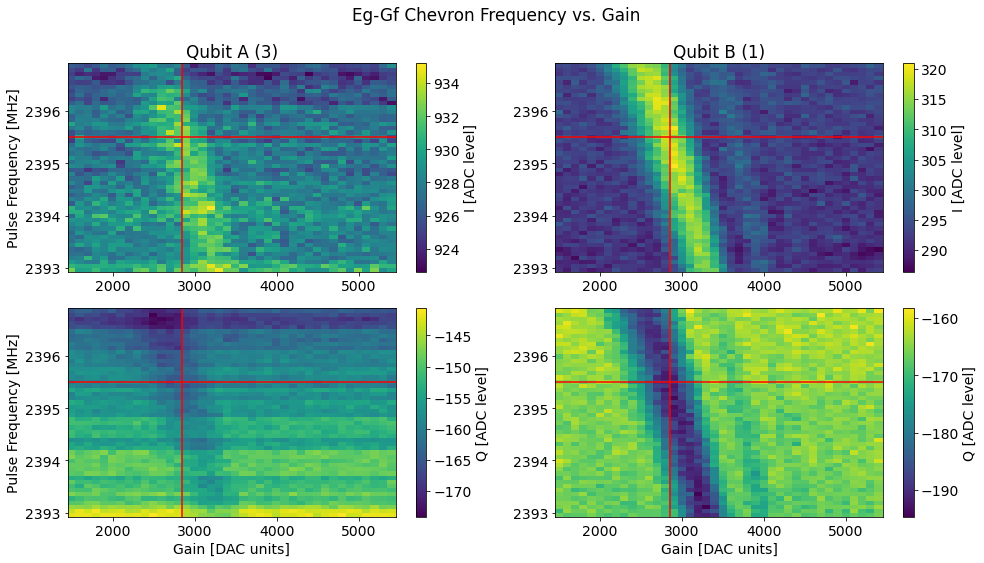

In [36]:
# # TESTING
# rabiEgGfChevron = meas.AmplitudeRabiEgGfExperiment(config_file=config_path)
# rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EgGf_qubit01.h5')
# data = rabiEgGfChevron.analyze(data=temp_data, fit=True)
# rabiEgGfChevron.display(data=data, fit=True)

rabiEgGfFreqGainChevron.analyze(data=None)
rabiEgGfFreqGainChevron.display(data=None, plot_freq=2395.5, plot_gain=2850)

In [37]:
rabiEgGfFreqGainChevron.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00000_rabi_EgGf_gainlen_chevron_qubit31.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_221215\\00000_rabi_EgGf_gainlen_chevron_qubit31.h5'

# Rabi eg-gf chevron (freq vs. len)

In [49]:
rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_gainlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_f = 4 # MHz
npts_f = 50
    
rabiEgGfFreqLenChevron.cfg.expt = dict(
    start_f=rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # start freq [MHz],
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f, # number of different freq experiments, 
    start_len=soc.cycles2us(0), # pulse length (sigma) [us]
    step_len=soc.cycles2us(8), # [us]
    expts_len=50,
    # gain=2700,
    reps=1000,
    pulse_type='const',
    qubits=qubits,
)

# rabiEgGfFreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiEgGfFreqLenChevron.cfg)

import Pyro4.util
try:
    rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [810.826541944993, 3464.727488396267, 145.572034953271, 425.57], 'f_Q1_ZZ': [3463.826339688734, 0, 3459.6698976969255, 3463.5104694090664], 'f_ef': [611.098326885819, 3364.253, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2010.8, 0, 2678.7, 2395.5], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [16026, 22147, 24653, 28755], 'sigma': [0.066, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [16026, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [27777, 0, 16840, 30000], 'sigma': [0.015, 0, 0.024187907740573854, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [4250, 0, 2679, 2850], 'sigma': [0.171, 0, 0.227, 0.293], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.886, -812.617, -73.825, 87.436], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.91, 0.86, 0.48, 0.75], 'readout_length': [10, 

  0%|          | 0/50 [00:00<?, ?it/s]

50


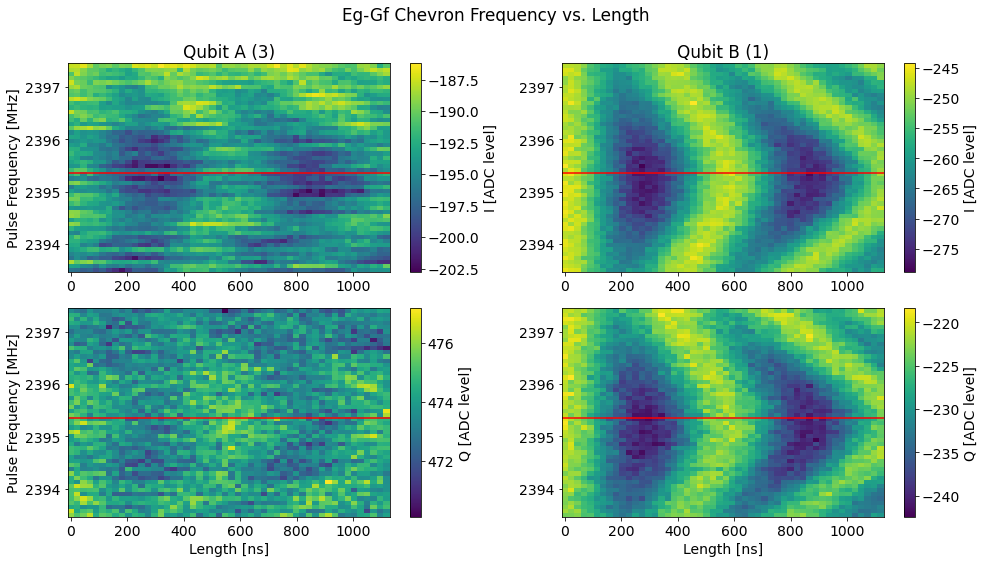

In [50]:
# # TESTING
# rabiEgGfChevron = meas.AmplitudeRabiEgGfExperiment(config_file=config_path)
# rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EgGf_qubit01.h5')
# data = rabiEgGfChevron.analyze(data=temp_data, fit=True)
# rabiEgGfChevron.display(data=data, fit=True)

rabiEgGfFreqLenChevron.analyze(data=None)
rabiEgGfFreqLenChevron.display(data=None, plot_freq=2395.35, plot_len=None)

In [24]:
rabiEgGfFreqLenChevron.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00001_rabi_EgGf_gainlen_chevron_qubit21.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_221215\\00001_rabi_EgGf_gainlen_chevron_qubit21.h5'

# Rabi eg-gf chevron (length vs. amplitude)

In [65]:
rabiEgGfLenGainChevron = meas.EgGfLenGainChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_gainlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_gain = 4000
npts_gain = 40
    
rabiEgGfLenGainChevron.cfg.expt = dict(
    start_gain=100, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    start_len=soc.cycles2us(0), # pulse length (sigma) [us]
    step_len=soc.cycles2us(10), # [us]
    expts_len=51,
    rounds=50,
    reps=10,
    # pi_EgGf_sigma=0.600, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='const',
    qubits=qubits,
)

# rabiEgGfLenGainChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfLenGainChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiEgGfLenGainChevron.cfg)

import Pyro4.util
try:
    rabiEgGfLenGainChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [97, 53, 46, 58], 'f_ge': [823.0681204610527, 3473.31, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [633.210668158286, 3364.2434148826505, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2014.48529442, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22692, 23585, 22539, 28755], 'sigma': [0.0386, 0.0217, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [12488, 15332, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3000, 0, 2750, 2850], 'sigma': [0.396, 0, 0.232, 0.29], 'type': 'flat_top'}}}, 'readout': {'trig_offset': 125, 'frequency': [814.069, -808.35, -79.784, 81.64542225717739], 'lo_sideband': [1, -1, 1, 1], 'gain': [

  0%|          | 0/51 [00:00<?, ?it/s]

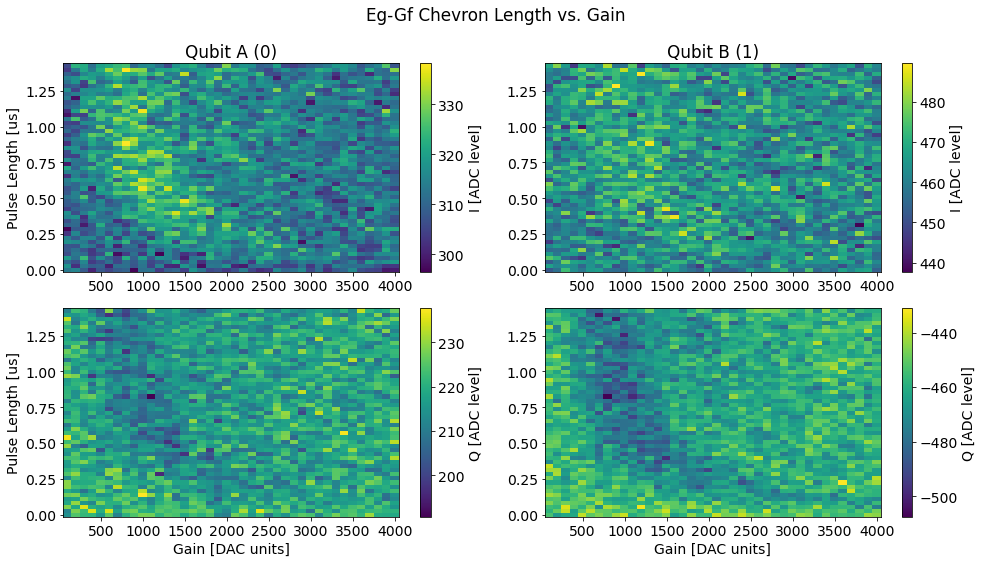

In [66]:
# # TESTING
# rabiEgGfChevron = meas.AmplitudeRabiEgGfExperiment(config_file=config_path)
# rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EgGf_qubit01.h5')
# data = rabiEgGfChevron.analyze(data=temp_data, fit=True)
# rabiEgGfChevron.display(data=data, fit=True)

rabiEgGfLenGainChevron.analyze(data=None)
rabiEgGfLenGainChevron.display(data=None)

In [67]:
rabiEgGfLenGainChevron.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_rabi_EgGf_gainlen_chevron_qubit01.h5


# Length Rabi eg-gf

In [ ]:
# soc.us2cycles(10)*150
5*soc.cycles2us(4, gen_ch=4)*1e3

33.38675213675214

In [45]:
lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

lengthrabiEgGf.cfg.expt = dict(
    start=soc.cycles2us(0), # pulse length (sigma) [us]
    step=soc.cycles2us(3), # [us]
    # step=0.001,
    expts=100,
    reps=2000,
    # gain=4250, # qubit gain [DAC units],
    pulse_type='const',
    qubits=qubits,
    singleshot=False,
)

# lengthrabiEgGf.cfg.device.readout.readout_length = [10,5] # [us]
print(lengthrabiEgGf.cfg)
# lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
import Pyro4.util
try:
    lengthrabiEgGf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [810.826541944993, 3464.727488396267, 145.572034953271, 425.57], 'f_Q1_ZZ': [3463.6655790699174, 0, 3459.718643790527, 3463.5163174610875], 'f_ef': [611.098326885819, 3364.253, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2010.8, 0, 2678.7, 2395.5], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [16026, 22147, 24653, 28755], 'sigma': [0.066, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [16026, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [30000, 0, 15880, 30000], 'sigma': [0.022877223175459725, 0, 0.05739835717369027, 0.016160253718707353], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [4250, 0, 2679, 2850], 'sigma': [0.171, 0, 0.227, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.946, -812.617, -73.825, 87.436], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.86, 0.86, 0.48, 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Pi length from avgi data (qubit A) [us]: 0.07587464303543384
	Pi/2 length from avgi data (qubit A) [us]: 0.03793732151771692
Pi length from avgq data (qubit A) [us]: 0.09872367771682634
	Pi/2 length from avgq data (qubit A) [us]: 0.04936183885841317
Pi length from avgi data (qubit B) [us]: 0.2926669371828635
	Pi/2 length from avgi data (qubit B) [us]: 0.14633346859143176
Pi length from avgq data (qubit B) [us]: 0.2917869726517459
	Pi/2 length from avgq data (qubit B) [us]: 0.14589348632587296


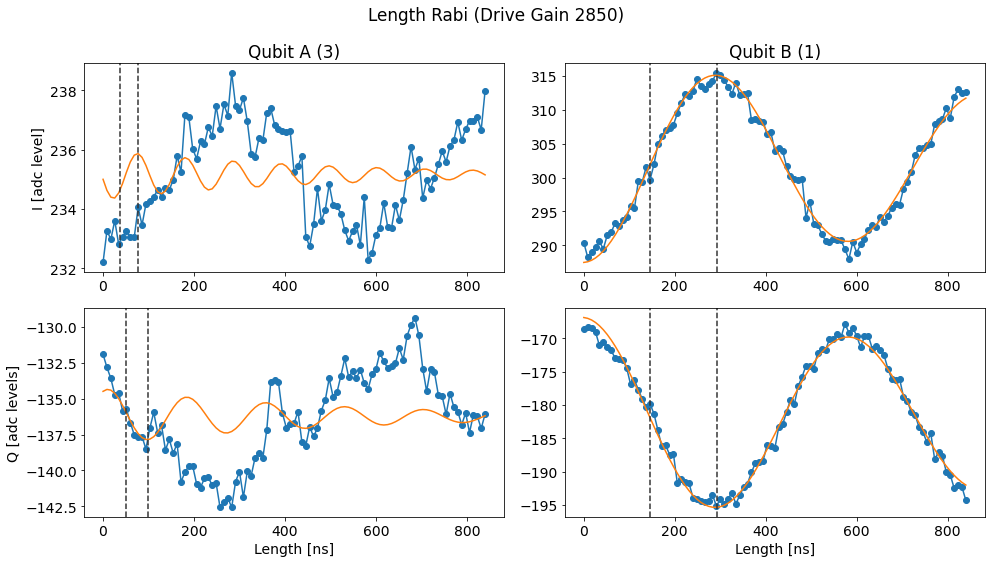

In [46]:
# # TESTING
# lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
# lengthrabiEgGf.display(data=data, fit=False)

lengthrabiEgGf.analyze(fit=True)
lengthrabiEgGf.display(fit=True)

In [47]:
lengthrabiEgGf.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00000_length_rabi_EgGf_qubit31.h5


# Amplitude Rabi eg-gf

In [ ]:
amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 1000
npts = 101
    
amprabiEgGf.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    # step=0.001,
    rounds=10,
    reps=500,
    # pi_EgGf_sigma=0.600, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='const',
    qubits=qubits,
    singleshot=False,
)

# amprabiEgGf.cfg.device.readout.readout_length = [15, 15] # [us]
# amprabiEgGf.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(amprabiEgGf.cfg)

import Pyro4.util
try:
    amprabiEgGf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [97, 53, 46, 58], 'f_ge': [823.0681204610527, 3473.31, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [633.210668158286, 3364.2434148826505, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2014.48529442, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22692, 23585, 22539, 28755], 'sigma': [0.0386, 0.0217, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [12488, 15332, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3000, 0, 2750, 2850], 'sigma': [0.396, 0, 0.232, 0.29], 'type': 'flat_top'}}}, 'readout': {'trig_offset': 125, 'frequency': [814.069, -808.35, -79.784, 81.64542225717739], 'lo_sideband': [1, -1, 1, 1], 'gain': [

  0%|          | 0/200 [00:00<?, ?it/s]

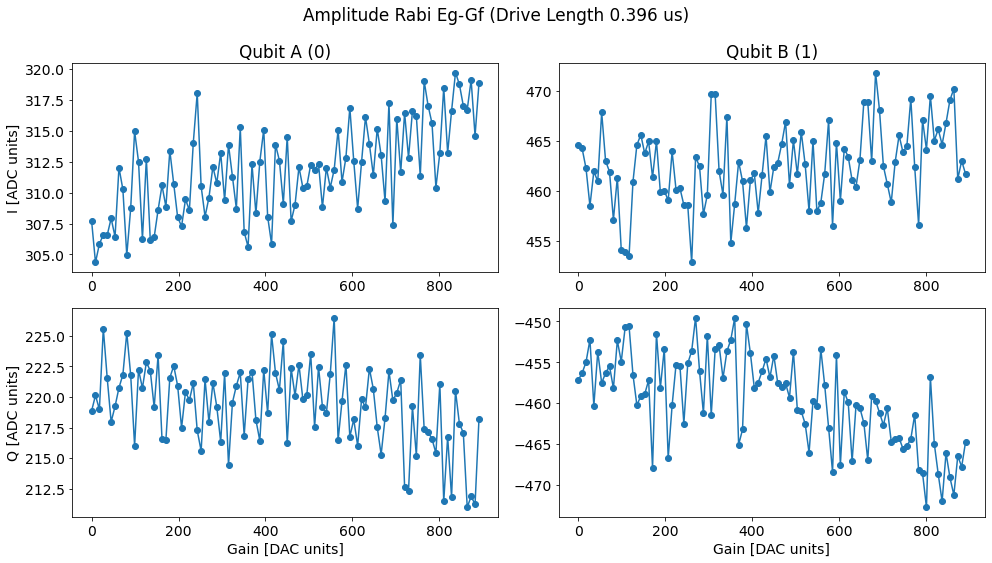

In [ ]:
# # TESTING
# amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(config_file=config_path)
# amprabiEgGf.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EgGf_qubit01.h5')
# data = amprabiEgGf.analyze(data=temp_data, fit=True)
# amprabiEgGf.display(data=data, fit=True)

# # apply mask onto data
# temp_data = dict()
# for key, value in amprabiEgGf.data.items():
#     if len(np.shape(value)) > 1:
#         temp_data.update({key:np.array([value[0][:50], value[1][:50]])})
#     else: temp_data.update({key:value[:50]})

amprabiEgGf.analyze(data=None, fit=True)
amprabiEgGf.display(data=None, fit=False)

In [ ]:
amprabiEgGf.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00000_amp_rabi_EgGf_qubit01.h5


In [ ]:
prog = amprabiEgGf.prog
shot_avg = 10
threshold = amprabiEgGf.cfg.device.readout.threshold
bufi = np.array([prog.di_buf[i] for i, ch in enumerate(prog.ro_chs)])
avgi = []
for bufi_ch in bufi:
    # drop extra shots that aren't divisible into averages
    new_bufi_ch = bufi_ch[:len(bufi_ch) - (len(bufi_ch) % shot_avg)]
    # average over shots_avg number of consecutive shots
    new_bufi_ch = np.reshape(new_bufi_ch, (len(new_bufi_ch)//shot_avg, shot_avg))
    new_bufi_ch = np.average(new_bufi_ch, axis=1)
    avgi.append(new_bufi_ch)
avgi = np.array(avgi)
shots = np.array([np.heaviside(avgi[i]/prog.ro_chs[ch].length-threshold[i], 0) for i, ch in enumerate(prog.ro_chs)])

qubits = prog.cfg.expt.qubits
# get the shots for the qubits we care about
shots = np.array([shots[prog.adc_chs[q]] for q in qubits])

# data is returned as n00, n01, n10, n11 measured for the two qubits
n00 = np.sum(np.logical_and(np.logical_not(shots[0]), np.logical_not(shots[1])))
n01 = np.sum(np.logical_and(np.logical_not(shots[0]), shots[1]))
n10 = np.sum(np.logical_and(shots[0], np.logical_not(shots[1])))
n11 = np.sum(np.logical_and(shots[0], shots[1]))
print(n00, n01, n10, n11)

50 23 16 11
